In [1]:
#import essential libraries 
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as T
from torchvision import models
import os
import pandas as pd
from torchvision.io import read_image
from sklearn.model_selection import train_test_split
from torch.optim import lr_scheduler
from torch.utils.data import Dataset
from torchvision.datasets import ImageFolder
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import time
import copy
from tqdm import tqdm
import numpy as np
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from tensorflow.keras import layers
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import random
import pdb

In [2]:
#%automatic reloading during training
%load_ext autoreload
%autoreload 2

In [3]:
# set seed for  reproduciblity of the code
random_seed = 2023 # or any of your favorite number 
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)

In [4]:
# Set the device, check GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


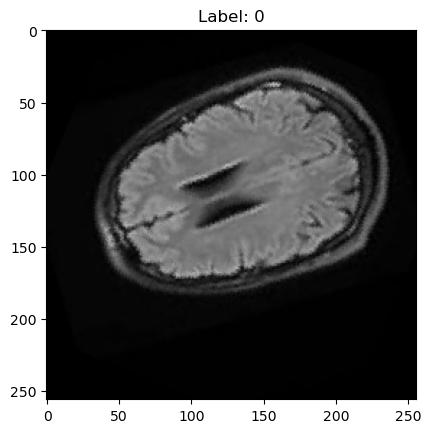

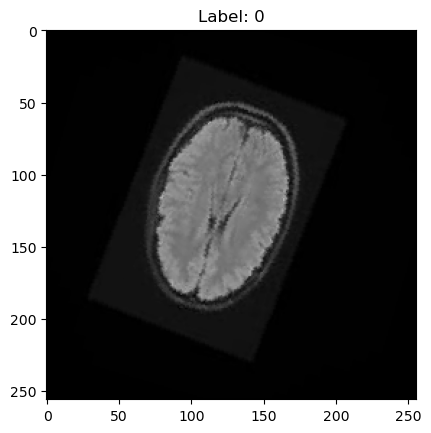

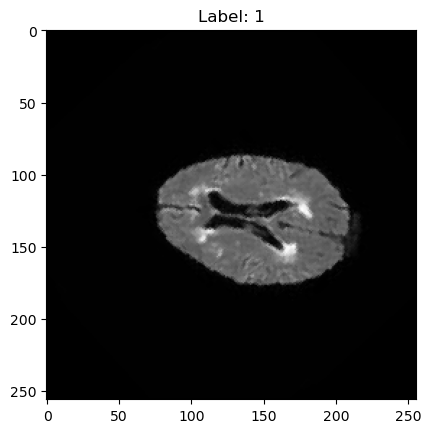

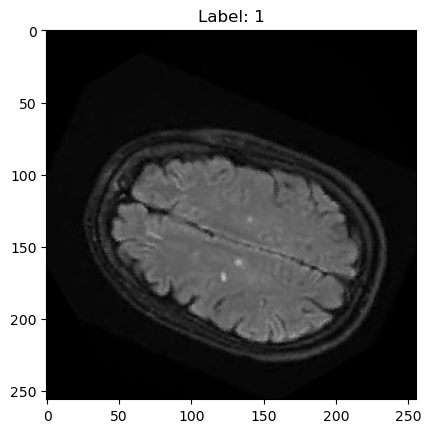

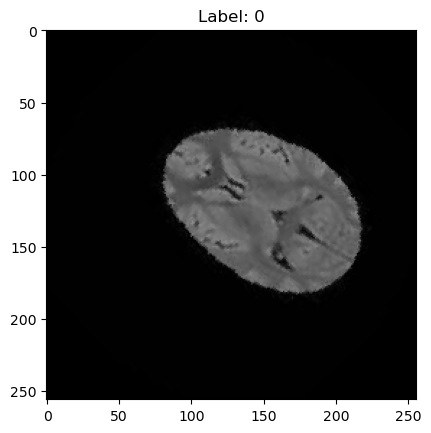

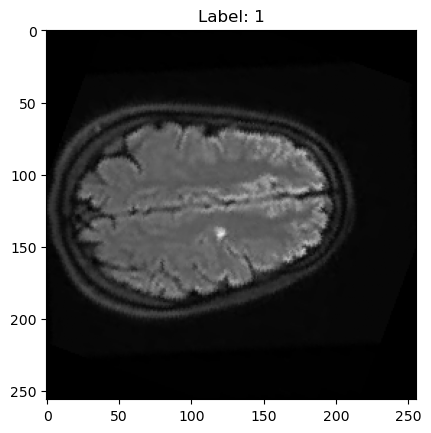

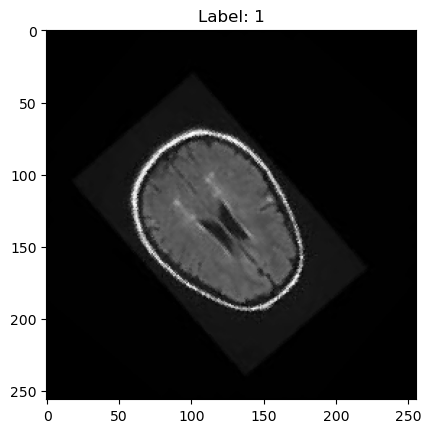

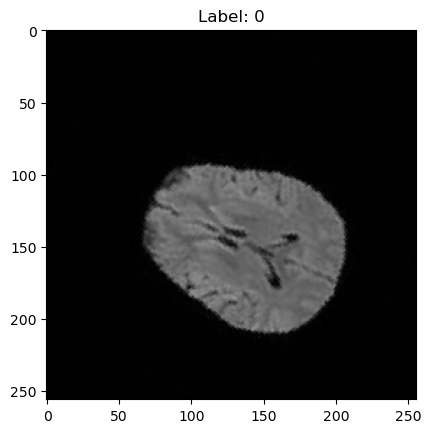

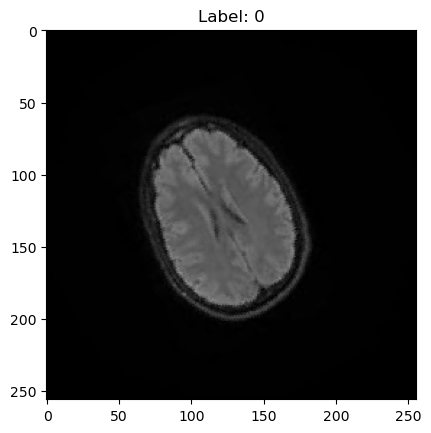

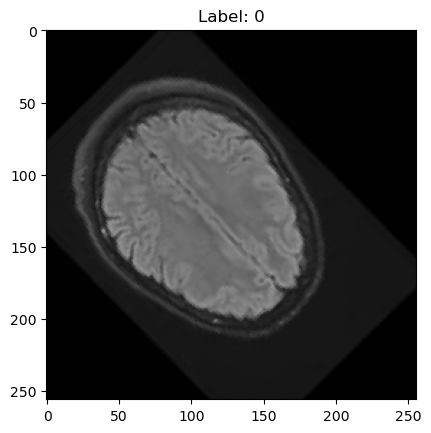

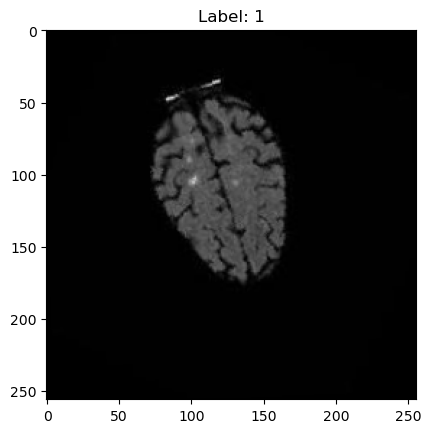

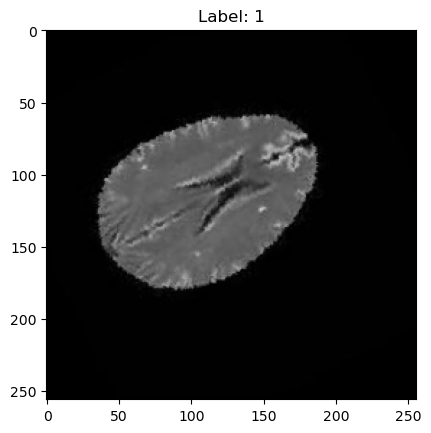

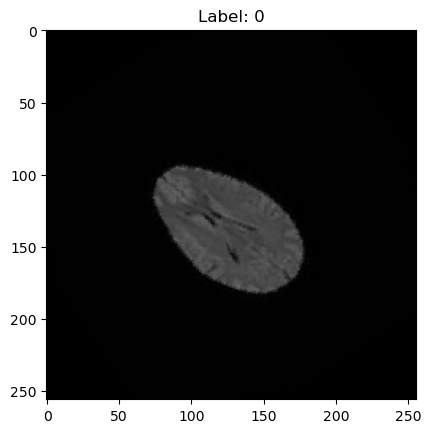

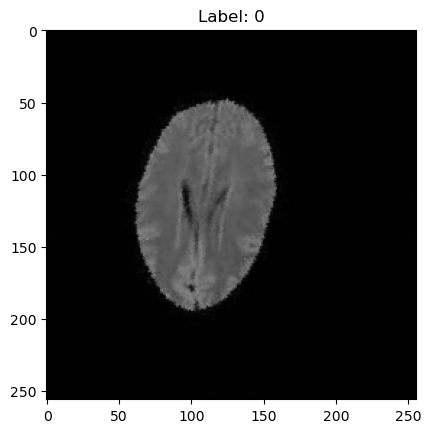

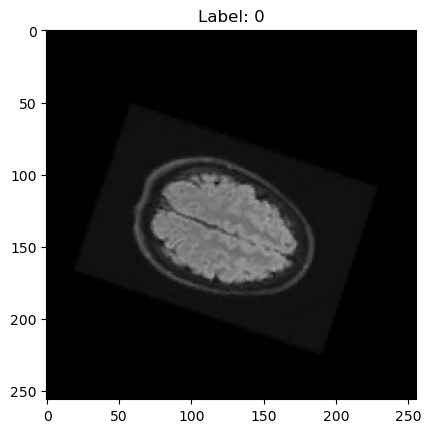

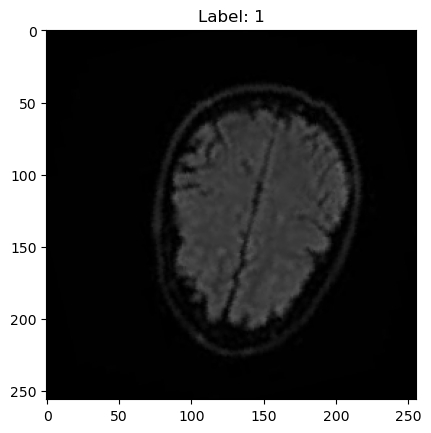

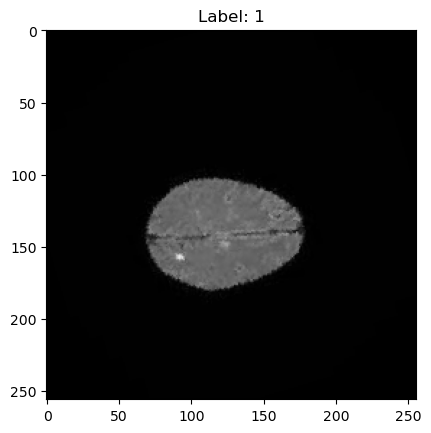

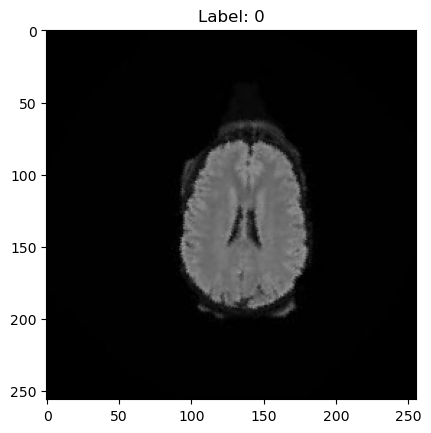

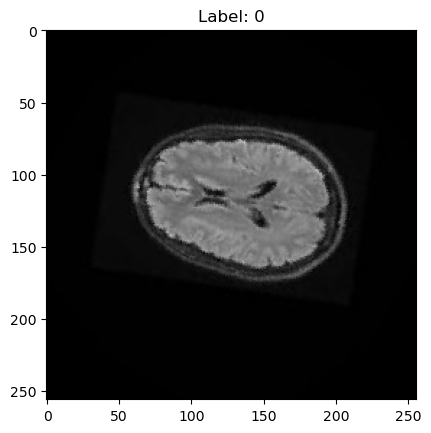

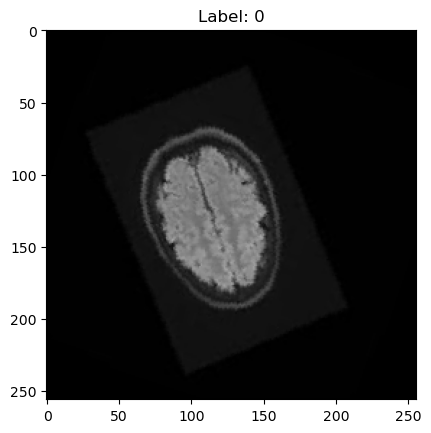

In [5]:
import os
import random
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import torch

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to 256x256
    transforms.RandomHorizontalFlip(),  # Add horizontal flipping
    transforms.RandomVerticalFlip(),  # Add vertical flipping
    
    transforms.RandomRotation(degrees=(-75, 75)),  # Add random rotation between -75 and 75 degrees
    transforms.ToTensor(),
    transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1])  # Normalize to [0, 1]
])  # Convert to PyTorch tensor


class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        # Load images from both classes internally
        self.root_dir = root_dir  # Store root_dir for use in load_data
        self.data_positive = self.load_data(positive_class=True)
        self.data_negative = self.load_data(positive_class=False)
        self.data = self.data_positive + self.data_negative
        random.shuffle(self.data)  # Shuffle the combined dataset
        self.transform = transform  # Assign the transform

    def load_data(self, positive_class=True):
        data = []
        class_name = 'MS' if positive_class else 'noMS'
        class_label = 1 if positive_class else 0
        class_path = os.path.join(self.root_dir, class_name)  # Use self.root_dir

        for filename in os.listdir(class_path):
            if filename.endswith(".jpg"):
                img_path = os.path.join(class_path, filename)
                data.append((img_path, class_label))

        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert("RGB")  # Ensure RGB format

        if self.transform:
            image = self.transform(image)  # Apply transformations

        return image, label

# Create the Dataset (balanced with both classes)
dataset = CustomDataset(root_dir='C:\\Users\\hajami\\Desktop\\535-data', transform=transform)

# Visualize samples
import matplotlib.pyplot as plt

for i in range(20):
    image, label = dataset[i]
    plt.imshow(image.permute(1, 2, 0))  # Rearrange dimensions for visualization
    plt.title(f"Label: {label}")
    plt.show()


In [6]:
# Define the transformation
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Adjust the size as needed
    transforms.ToTensor(),
])
dataset = CustomDataset(root_dir='C:\\Users\\hajami\\Desktop\\535-data', transform=transform)

In [7]:
#split the dataset 
from torch.utils.data import random_split

# Split the dataset into train, validation, and test sets
train_size = int(0.70 * len(dataset))
val_size = int(0.20 * len(dataset))
test_size = len(dataset) - train_size - val_size  # Corrected calculation

train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

# Access the individual datasets
print(len(train_data))  # Number of samples in the training set
print(len(val_data))    # Number of samples in the validation set
print(len(test_data))   # Number of samples in the test set

21420
6120
3060


In [8]:
#define the dataloader for training and testing loops
from torch.utils.data import DataLoader

train_len = len(train_data)
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)

val_len = len(val_data)
val_dataloader = DataLoader(val_data, batch_size=32, shuffle=True)

test_len = len(test_data)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False)

data_loaders = {'train':train_dataloader, 'val':val_dataloader}

In [9]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]

Feature batch shape: torch.Size([32, 3, 256, 256])
Labels batch shape: torch.Size([32])


In [10]:
print(torch.cuda.is_available())

True


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.autograd import Variable
from sklearn.metrics import f1_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from PIL import Image
import os
import random
import matplotlib.pyplot as plt
class BetaVAEClassifier(nn.Module):
    def __init__(self, input_shape, latent_dim, beta):
        super(BetaVAEClassifier, self).__init__()

        # Encoder
        self.encoder_conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.encoder_relu1 = nn.ReLU()  # Combine BatchNorm and ReLU into a single layer

        self.encoder_fc1 = nn.Linear(32 * 256 * 256, latent_dim)

        # Reparameterization trick
        self.sampling = lambda mean, log_var: mean + torch.exp(0.5 * log_var) * torch.randn_like(mean)

        # Classifier head
        self.classifier_fc = nn.Linear(latent_dim, 1)

        # Decoder
       # self.decoder_fc1 = nn.Linear(latent_dim, 32 * 256 * 256)
        self.decoder_fc1 = nn.Linear(latent_dim, 3 * 256 * 256)  # Update the output dimension here

        self.decoder_relu1 = nn.ReLU()  # Combine BatchNorm and ReLU into a single layer

        self.decoder_conv_t1 = nn.ConvTranspose2d(32, 3, kernel_size=3, stride=1, padding=1)

        # Define optimizer as a variable
        self.optimizer = None

        # Add the device attribute
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def set_optimizer(self, optimizer_name, learning_rate):
        # Available optimizers and their arguments
        optimizers = {
            "adam": optim.Adam(self.parameters(), lr=learning_rate),
            "sgd": optim.SGD(self.parameters(), lr=learning_rate),
            # Add other optimizers as needed
        }
        self.optimizer = optimizers.get(optimizer_name)
        if self.optimizer is None:
            raise ValueError(f"Invalid optimizer name: {optimizer_name}")

    def forward(self, x):
        # Encoder
        x = self.encoder_conv1(x)
        x = self.encoder_relu1(x)

        x = x.view(x.size(0), -1)
        mean = self.encoder_fc1(x)
        log_var = self.encoder_fc1(x)  # Reuse the first FC layer for efficiency

        # Reparameterization trick
        z = self.sampling(mean, log_var)

        # Classifier head
        classification_output = self.classifier_fc(z)
       
        # Decoder
        z = self.sampling(mean, log_var)
        recon_batch = self.decoder_fc1(z)  # Linear layer output
        recon_batch = recon_batch.view(-1, 3, 256, 256)  # Reshape to match image size

        # Additional layer to transform 32 channels to 3 channels
        self.decoder_conv_t2 = nn.ConvTranspose2d(3, 3, kernel_size=3, stride=1, padding=1)

        # Move the ConvTranspose2d layer to the GPU
        self.decoder_conv_t2 = self.decoder_conv_t2.to(self.device)

        # Apply the additional layer
        recon_batch = self.decoder_conv_t2(recon_batch)

        # Print the shape after the reshape for debugging
        #print("Decoder Output Shape After Reshape:", recon_batch.size())


        return recon_batch, classification_output, mean, log_var


In [12]:
import torch
from torch import nn, optim  # Assuming these are from torch
import matplotlib.pyplot as plt  # Import for plotting

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create the Beta-VAE with Classifier
input_shape = (3, 256, 256)
latent_dim = 20
beta = 20
vae_classifier = BetaVAEClassifier(input_shape, latent_dim, beta)

# Move the model to the device
vae_classifier.to(device)

# Define the loss functions
criterion_recon = nn.MSELoss()
criterion_class = nn.BCEWithLogitsLoss()

# Define the optimizer
optimizer = optim.Adam(vae_classifier.parameters(), lr=0.000001)

def train_epoch(model, loader, optimizer, criterion_recon, criterion_class):
    model.train()
    total_loss_recon = 0.0
    total_loss_class = 0.0
    total_correct_pos = 0
    total_correct_neg = 0
    running_loss = 0.0  # Initialize running_loss
    correct_predictions = 0
    total_predictions = 0

    for batch in loader:
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        recon_batch, class_output, _, _ = model(images)

        loss_recon = criterion_recon(recon_batch, images)
        loss_class = criterion_class(class_output.squeeze(), labels.float())

        total_loss_recon += loss_recon.item()
        total_loss_class += loss_class.item()

        loss = loss_recon + loss_class
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()  # Update running_loss

        # Calculate accuracy for positive and negative sets separately
        predictions = (class_output.squeeze() > 0).int()
        correct = (predictions == labels).sum().item()
        correct_predictions += correct
        total_predictions += labels.size(0)

    avg_loss_recon = total_loss_recon / len(loader)
    avg_loss_class = total_loss_class / len(loader)
    avg_train_loss = running_loss / len(loader)  # Calculate average training loss
    avg_accuracy = correct_predictions / total_predictions

    return avg_loss_recon, avg_loss_class, avg_train_loss, avg_accuracy


def validate(model, loader, criterion_recon, criterion_class):
    model.eval()
    total_loss_recon = 0.0
    total_loss_class = 0.0
    total_correct = 0
    total_predictions = 0

    with torch.no_grad():
        for batch in loader:
            images, labels = batch
            images = images.to(device)
            labels = labels.to(device)

            recon_batch, class_output, _, _ = model(images)

            loss_recon = criterion_recon(recon_batch, images)
            loss_class = criterion_class(class_output.squeeze(), labels.float())

            total_loss_recon += loss_recon.item()
            total_loss_class += loss_class.item()

            predictions = (class_output.squeeze() > 0).int()
            correct = (predictions == labels).sum().item()
            total_correct += correct
            total_predictions += labels.size(0)

    avg_loss_recon = total_loss_recon / len(loader)
    avg_loss_class = total_loss_class / len(loader)
    avg_accuracy = total_correct / total_predictions

    # Return all validation losses and accuracy
    return avg_loss_recon, avg_loss_class, avg_accuracy


def test(model, loader, criterion_recon, criterion_class):
    model.eval()
    total_loss_recon = 0.0
    total_loss_class = 0.0
    total_correct = 0
    total_predictions = 0

    with torch.no_grad():
        for batch in loader:
            images, labels = batch
            images = images.to(device)
            labels = labels.to(device)

            recon_batch, class_output, _, _ = model(images)

            loss_recon = criterion_recon(recon_batch, images)
            loss_class = criterion_class(class_output.squeeze(), labels.float())

            total_loss_recon += loss_recon.item()
            total_loss_class += loss_class.item()

            predictions = (class_output.squeeze() > 0).int()
            correct = (predictions == labels).sum().item()
            total_correct += correct
            total_predictions += labels.size(0)

    avg_loss_recon = total_loss_recon / len(loader)
    avg_loss_class = total_loss_class / len(loader)
    avg_accuracy = total_correct / total_predictions

    return avg_loss_recon, avg_loss_class, avg_accuracy

# Training loop
num_epochs = 40
train_losses = []
val_losses = []  # List to store validation losses
train_accuracies = []
val_accuracies = []
test_accuracies = []  # List to store test accuracies

for epoch in range(num_epochs):
    running_loss = 0.0  # Initialize running_loss for each epoch
    epoch_train_loss = 0.0  # Renamed for clarity

    # Training loop
    avg_loss_recon, avg_loss_class, avg_train_loss, train_accuracy = train_epoch(vae_classifier, train_dataloader, optimizer, criterion_recon, criterion_class)
    train_accuracies.append(train_accuracy)

    # Validate on validation set
    val_loss_recon, val_loss_class, val_accuracy = validate(vae_classifier, val_dataloader, criterion_recon, criterion_class)
    val_losses.append(val_loss_recon + val_loss_class)  # Combine validation losses
    val_accuracies.append(val_accuracy)

    # Test the model on test set
    test_loss_recon, test_loss_class, test_accuracy = test(vae_classifier, test_dataloader, criterion_recon, criterion_class)
    test_accuracies.append(test_accuracy)

    # Store losses for plotting
    train_losses.append(avg_train_loss)

    # Print the results
    print(f"Epoch {epoch + 1}/{num_epochs} - Avg. Train Loss: {avg_train_loss:.4f} - Train Accuracy: {train_accuracy:.4f} - Val Loss: {val_loss_recon + val_loss_class:.4f} - Val Accuracy: {val_accuracy:.4f} - Test Accuracy: {test_accuracy:.4f}")


Epoch 1/40 - Avg. Train Loss: 0.8154 - Train Accuracy: 0.5965 - Val Loss: 0.7925 - Val Accuracy: 0.6359 - Test Accuracy: 0.6572
Epoch 2/40 - Avg. Train Loss: 0.7783 - Train Accuracy: 0.6474 - Val Loss: 0.7684 - Val Accuracy: 0.6614 - Test Accuracy: 0.6663
Epoch 3/40 - Avg. Train Loss: 0.7530 - Train Accuracy: 0.6756 - Val Loss: 0.7396 - Val Accuracy: 0.6930 - Test Accuracy: 0.6814
Epoch 4/40 - Avg. Train Loss: 0.7334 - Train Accuracy: 0.6988 - Val Loss: 0.7268 - Val Accuracy: 0.7127 - Test Accuracy: 0.7219
Epoch 5/40 - Avg. Train Loss: 0.7121 - Train Accuracy: 0.7208 - Val Loss: 0.7008 - Val Accuracy: 0.7340 - Test Accuracy: 0.7402
Epoch 6/40 - Avg. Train Loss: 0.6977 - Train Accuracy: 0.7394 - Val Loss: 0.7001 - Val Accuracy: 0.7408 - Test Accuracy: 0.7471
Epoch 7/40 - Avg. Train Loss: 0.6811 - Train Accuracy: 0.7583 - Val Loss: 0.6754 - Val Accuracy: 0.7588 - Test Accuracy: 0.7673
Epoch 8/40 - Avg. Train Loss: 0.6720 - Train Accuracy: 0.7650 - Val Loss: 0.6683 - Val Accuracy: 0.7717 

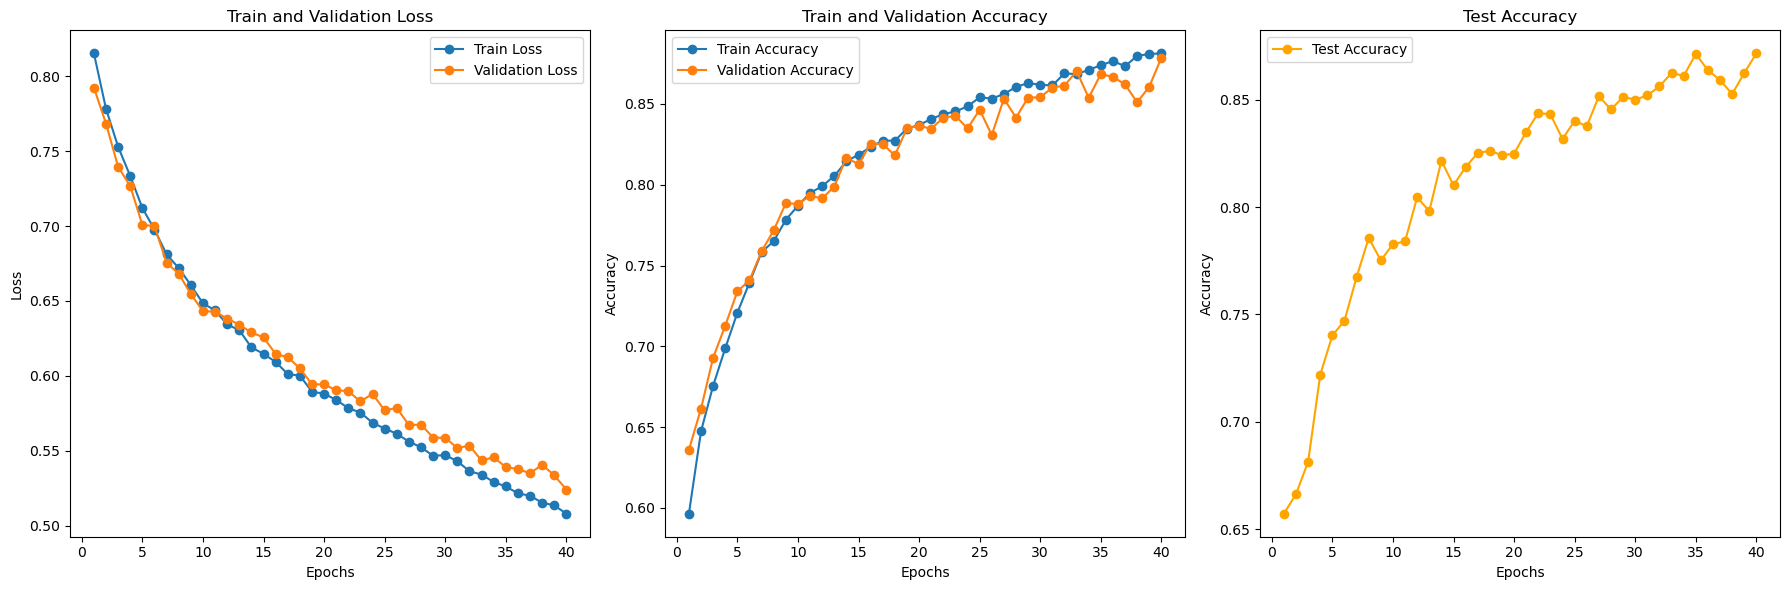

In [13]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(18, 6))  # Increase figure size for accommodating the third subplot

# Plot train loss
plt.subplot(1, 3, 1)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot train accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(epochs, val_accuracies, label='Validation Accuracy', marker='o')
plt.title('Train and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot test accuracy
plt.subplot(1, 3, 3)
plt.plot(epochs, test_accuracies, label='Test Accuracy', marker='o', color='orange')
plt.title('Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Function to calculate metrics
def calculate_metrics(predictions, targets):
    accuracy = accuracy_score(targets, predictions)
    precision = precision_score(targets, predictions)
    recall = recall_score(targets, predictions)
    f1 = f1_score(targets, predictions)
    return accuracy, precision, recall, f1

# Evaluate on validation set
val_predictions = []
val_targets = []
for batch in val_dataloader:
    images, labels = batch
    images = images.to(device)
    labels = labels.to(device)
    _, class_output, _, _ = vae_classifier(images)
    predictions = (class_output.squeeze() > 0).int().cpu().numpy()
    val_predictions.extend(predictions)
    val_targets.extend(labels.cpu().numpy())

val_accuracy, val_precision, val_recall, val_f1 = calculate_metrics(val_predictions, val_targets)
print("Validation Metrics:")
print(f"Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1 Score: {val_f1:.4f}")

# Evaluate on test set
test_predictions = []
test_targets = []
for batch in test_dataloader:
    images, labels = batch
    images = images.to(device)
    labels = labels.to(device)
    _, class_output, _, _ = vae_classifier(images)
    predictions = (class_output.squeeze() > 0).int().cpu().numpy()
    test_predictions.extend(predictions)
    test_targets.extend(labels.cpu().numpy())

test_accuracy, test_precision, test_recall, test_f1 = calculate_metrics(test_predictions, test_targets)
print("Test Metrics:")
print(f"Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1 Score: {test_f1:.4f}")


Validation Metrics:
Accuracy: 0.8781, Precision: 0.8734, Recall: 0.8837, F1 Score: 0.8785
Test Metrics:
Accuracy: 0.8761, Precision: 0.8766, Recall: 0.8761, F1 Score: 0.8763


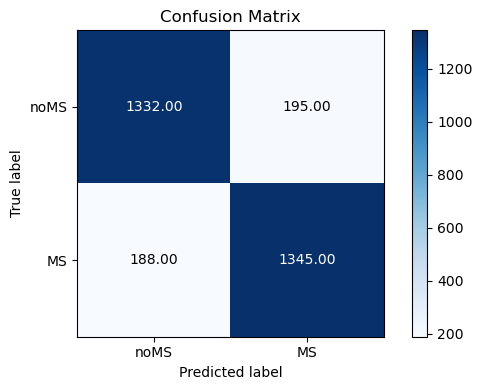

In [15]:
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(model, loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for batch in loader:
            images, labels = batch
            images = images.to(device)
            labels = labels.to(device)

            _, class_output, _, _ = model(images)

            predictions = (class_output.squeeze() > 0).int()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())

    # Compute confusion matrix
    cm = np.zeros((2, 2))
    for i in range(len(y_true)):
        cm[y_true[i], y_pred[i]] += 1

    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['noMS', 'MS'])
    plt.yticks(tick_marks, ['noMS', 'MS'])

    fmt = '.2f' 
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Call the function to plot confusion matrix
plot_confusion_matrix(vae_classifier, test_dataloader)
